<a href="https://colab.research.google.com/github/visiont3lab/deep-learning-course/blob/main/colab/ObjectDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Single Object detection project

## Step 1) Use CVAT data annotation tool to  Collect Data

* [Annotation CVAT  Github](https://github.com/openvinotoolkit/cvat)

1. Accedere al sito [Annotation CVAT  Online](https://cvat.org/)
2. Creare un account
3. Eseguire login
4. Creare un nuovo progetto (face-custo-keypoints)
5. Selezionare Constructor e configurare le labels ( eye-point-left, eye-point-right, face-rect, nose)
6. Creare e Aprire il progetto
7. Creare le label
8. Esportare le label come **CVAT for images 1.1**

In [1]:
# wget a file from google drive -- https://silicondales.com/tutorials/g-suite/how-to-wget-files-from-google-drive/
# Dataset link: https://drive.google.com/file/d/12ob_5b-A0afVNjhPkmlNPgKIaM5tnA3m/view
# Use the below to wget in large files (over 100MB) from Google Drive. Added by Robin Scott of SiliconDales.com. See full instructions at https://silicondales.com/tutorials/g-suite/how-to-wget-files-from-google-drive/
# wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=FILE_ID' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=FILE_ID" -O FILE_NAME && rm -rf /tmp/cookies.txt
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=12ob_5b-A0afVNjhPkmlNPgKIaM5tnA3m' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=12ob_5b-A0afVNjhPkmlNPgKIaM5tnA3m" -O dataset.zip && rm -rf /tmp/cookies.txt
!unzip dataset.zip 

--2021-04-07 14:27:10--  https://docs.google.com/uc?export=download&confirm=1CjJ&id=12ob_5b-A0afVNjhPkmlNPgKIaM5tnA3m
Resolving docs.google.com (docs.google.com)... 172.217.13.238, 2607:f8b0:4004:811::200e
Connecting to docs.google.com (docs.google.com)|172.217.13.238|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0k-9k-docs.googleusercontent.com/docs/securesc/355nbk1i8a3tssdjml0sunafoivvgutg/va71e9kuktig5dceprvdghecgpnbihtk/1617805575000/08570269800297767338/16105472404985142358Z/12ob_5b-A0afVNjhPkmlNPgKIaM5tnA3m?e=download [following]
--2021-04-07 14:27:11--  https://doc-0k-9k-docs.googleusercontent.com/docs/securesc/355nbk1i8a3tssdjml0sunafoivvgutg/va71e9kuktig5dceprvdghecgpnbihtk/1617805575000/08570269800297767338/16105472404985142358Z/12ob_5b-A0afVNjhPkmlNPgKIaM5tnA3m?e=download
Resolving doc-0k-9k-docs.googleusercontent.com (doc-0k-9k-docs.googleusercontent.com)... 172.217.2.97, 2607:f8b0:4004:80a::2001
Connecting to doc-0k-

In [2]:
import xml.etree.ElementTree as ET
import pandas as pd 

# CVAT for images 1.1
# Labels --> filename xc,yc,w,h --> coordinate 0-1 --> coco dataset

mydict = {"filename": [],  "xc": [] ,"yc": [],"w": [],"h": []}
xml_file = "dataset/annotations.xml"
tree = ET.parse(xml_file)
root = tree.getroot()
for image in root:
    if image.tag=="image":
        #print(image.tag, image.attrib)
        iW = float(image.attrib["width"])
        iH = float(image.attrib["height"])
        for box in image:
            #print(box.attrib)
            bW = float(box.attrib["xbr"]) - float(box.attrib["xtl"])
            bH = float(box.attrib["ybr"]) - float(box.attrib["ytl"])
            xc =  float(box.attrib["xtl"]) + bW/ 2.0  # ---> xc : W = xcN : 1
            yc =  float(box.attrib["ytl"]) + bH/ 2.0  # ---> yc : W = ycN : 1
            xcN = xc / iW
            ycN = yc / iH
            bWN = bW / iW
            bHN = bH / iH
            mydict["filename"].append(image.attrib["name"])
            mydict["xc"].append(xcN)
            mydict["yc"].append(ycN)
            mydict["w"].append(bWN)
            mydict["h"].append(bHN)
            
df = pd.DataFrame(mydict)
df.to_csv("dataset/annotations.csv", index=None)

## Step 2) Include library Library and Utils

In [3]:
import os
from PIL import Image,ImageFont,ImageDraw
import numpy as np

from torch.utils.data import Dataset
import torch
import torchvision
import torchvision.transforms as transforms
import pandas as pd

## Step 3) Understading data augmentation: Data Augmentation Transformations

In [13]:
import torchvision.transforms.functional as TF
import random 

def resize_img_label(image,label=(0.,0.),target_size=(256,256)):
    w_orig,h_orig = image.size   
    w_target,h_target = target_size
    cx, cy= label
    
    # resize image and label
    image_new = TF.resize(image,target_size)
    label_new= cx/w_orig*w_target, cy/h_orig*h_target
    
    return image_new,label_new

def random_hflip(image,label):
    w,h=image.size
    x,y=label        

    image = TF.hflip(image)
    label = w-x, y
    return image,label

def random_vflip(image,label):
    w,h=image.size
    x,y=label
    image = TF.vflip(image)
    label = x, h-y
    return image, label

def random_shift(image,label,max_translate=(0.2,0.2)):
    w,h=image.size
    max_t_w, max_t_h=max_translate
    cx, cy=label

    # translate coeficinet, random [-1,1]
    trans_coef=np.random.rand()*2-1
    w_t = int(trans_coef*max_t_w*w)
    h_t = int(trans_coef*max_t_h*h)

    image=TF.affine(image,translate=(w_t, h_t),shear=0,angle=0,scale=1)
    label = cx+w_t, cy+h_t
        
    return image,label

def transformer(image, label, params):
    image,label=resize_img_label(image,label,params["target_size"])

    if random.random() < params["p_hflip"]:
        image,label=random_hflip(image,label)
        
    if random.random() < params["p_vflip"]:            
        image,label=random_vflip(image,label)
        
    if random.random() < params["p_shift"]:                            
        image,label=random_shift(image,label, params["max_translate"])

    if random.random() < params["p_brightness"]:
        brightness_factor=1+(np.random.rand()*2-1)*params["brightness_factor"]
        image=TF.adjust_brightness(image,brightness_factor)

    if random.random() < params["p_contrast"]:
        contrast_factor=1+(np.random.rand()*2-1)*params["contrast_factor"]
        image=TF.adjust_contrast(image,contrast_factor)

    if random.random() < params["p_gamma"]:
        gamma=1+(np.random.rand()*2-1)*params["gamma"]
        image=TF.adjust_gamma(image,gamma)

    if params["scale_label"]:
        label=scale_label(label,params["target_size"])
        
    image=TF.to_tensor(image)
    return image, label

def scale_label(a,b):
    div = [ai/bi for ai,bi in zip(a,b)]
    return div

'''
params_aug={
    "target_size" : (416, 416),
    "p_hflip" : 0.6,
    "p_vflip" : 0.0,
    "p_shift" : 0.6,
    "max_translate": (0.3, 0.2),
    "p_brightness": 0.8,
    "brightness_factor": 0.5,
    "p_contrast": 0.6,
    "contrast_factor": 0.6,
    "p_gamma": 0.5,
    "gamma": 0.4,
    "scale_label": True,
}

imgs = []
for x,y in train_dl:
    for im,l in zip(x,y):
        # normalized coordinates
        xcN,ycN,wN,hN = l.tolist()
        W,H = params_aug["target_size"]
        xc,yc,_,_ = rescale_bbox((xcN,ycN,wN,hN),W,H)
        img = TF.to_pil_image(im)
        imt,l_temp=transformer(img,(xc,yc),params_aug)
        xct, yct = l_temp
        lt = torch.tensor([xct,yct,wN,hN],dtype=torch.float32)
        imgs.append( TF.to_tensor( get_img_bbox(imt,lt,classNames,colors,labelScaled=True) ) ) 
        #break
grid =torchvision.utils.make_grid(torch.stack(imgs,dim=0), nrow=5, padding=5)
display(transforms.ToPILImage()(grid))  
'''

'\nparams_aug={\n    "target_size" : (416, 416),\n    "p_hflip" : 0.6,\n    "p_vflip" : 0.0,\n    "p_shift" : 0.6,\n    "max_translate": (0.3, 0.2),\n    "p_brightness": 0.8,\n    "brightness_factor": 0.5,\n    "p_contrast": 0.6,\n    "contrast_factor": 0.6,\n    "p_gamma": 0.5,\n    "gamma": 0.4,\n    "scale_label": True,\n}\n\nimgs = []\nfor x,y in train_dl:\n    for im,l in zip(x,y):\n        # normalized coordinates\n        xcN,ycN,wN,hN = l.tolist()\n        W,H = params_aug["target_size"]\n        xc,yc,_,_ = rescale_bbox((xcN,ycN,wN,hN),W,H)\n        img = TF.to_pil_image(im)\n        imt,l_temp=transformer(img,(xc,yc),params_aug)\n        xct, yct = l_temp\n        lt = torch.tensor([xct,yct,wN,hN],dtype=torch.float32)\n        imgs.append( TF.to_tensor( get_img_bbox(imt,lt,classNames,colors,labelScaled=True) ) ) \n        #break\ngrid =torchvision.utils.make_grid(torch.stack(imgs,dim=0), nrow=5, padding=5)\ndisplay(transforms.ToPILImage()(grid))  \n'

## Step 4) Dataset Preparation ( Dataset, DataLoader, Data Augmentation ) 

In [5]:
!wget https://github.com/Phonbopit/sarabun-webfont/raw/master/fonts/thsarabunnew-webfont.ttf

--2021-04-07 14:27:29--  https://github.com/Phonbopit/sarabun-webfont/raw/master/fonts/thsarabunnew-webfont.ttf
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/Phonbopit/sarabun-webfont/master/fonts/thsarabunnew-webfont.ttf [following]
--2021-04-07 14:27:29--  https://raw.githubusercontent.com/Phonbopit/sarabun-webfont/master/fonts/thsarabunnew-webfont.ttf
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 98308 (96K) [application/octet-stream]
Saving to: ‘thsarabunnew-webfont.ttf’

thsarabunnew-webfon 100%[===================>]  96.00K  --.-KB/s    in 0.003s  

2021-04-07 14:27:29 (34.4 MB/s) - ‘t

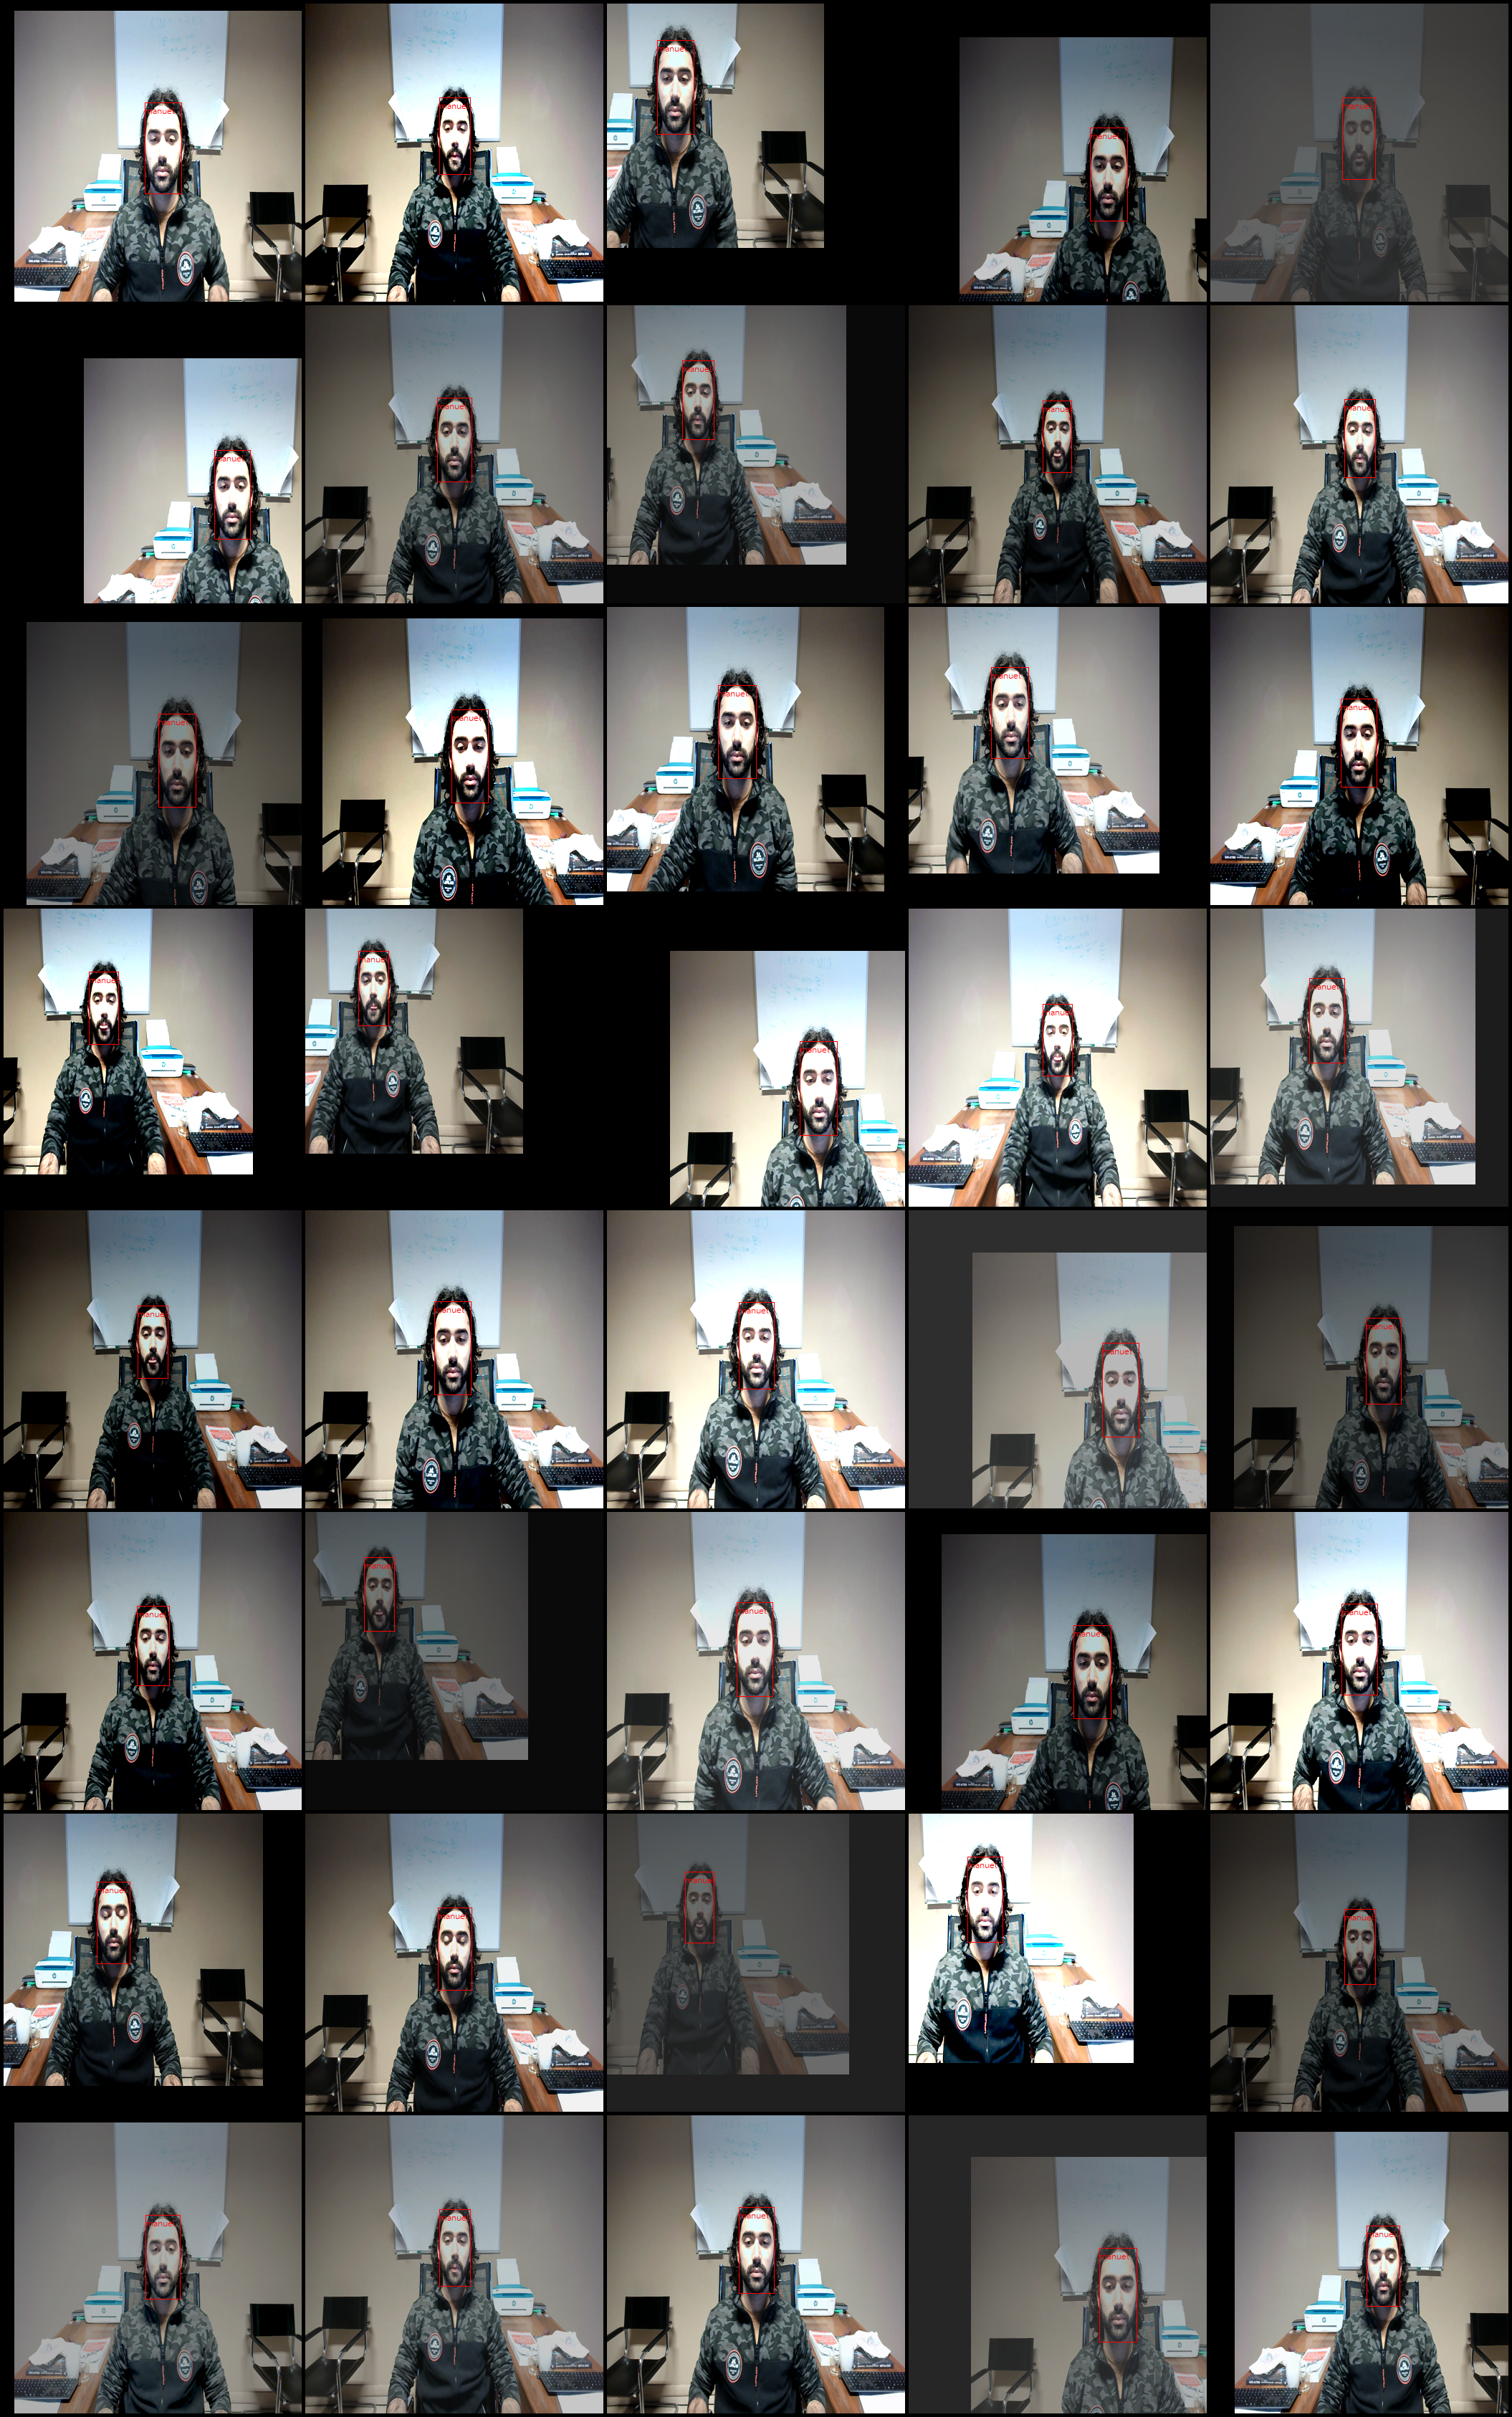

In [14]:
def rescale_bbox(bb,W,H):
    # rescale coordiante 0-1 to W-H (original size)
    x,y,w,h = bb
    return [x*W,y*H,w*W,h*H]

def get_img_bbox(imageTensor,labelTensor,classNames,colors,labelScaled=True):
    fnt = ImageFont.truetype('thsarabunnew-webfont.ttf',12)
    imagePil = transforms.ToPILImage()(imageTensor)
    bbox = labelTensor.tolist()
    W,H = imagePil.size
    draw = ImageDraw.Draw(imagePil)
    name = classNames[0]
    if labelScaled:
        bbox = rescale_bbox(bbox,W,H)
    xc,yc,w,h = bbox
    draw.rectangle( [(xc-w/2,yc-h/2), (xc+w/2,yc+h/2)], outline=tuple(colors[0]),width=1)
    draw.text( (xc-w/2,yc-h/2), name, font=fnt, fill=(255,0,0,0) )
    return imagePil

def compare_img_bbox(imageTensor,labelTensor,labelEstimatedTensor):
    fnt = ImageFont.truetype('thsarabunnew-webfont.ttf',12)
    imagePil = transforms.ToPILImage()(imageTensor)
    for l,c in zip([labelTensor,labelEstimatedTensor],[(255,0,0),(0,255,0)]):
        bbox = l.tolist()
        W,H = imagePil.size
        draw = ImageDraw.Draw(imagePil)
        bbox = rescale_bbox(bbox,W,H)
        xc,yc,w,h = bbox
        draw.rectangle( [(xc-w/2,yc-h/2), (xc+w/2,yc+h/2)], outline=tuple(c),width=1)
    return imagePil

def get_transforms(target_size):
    train_tf = transforms.Compose([
            transforms.Resize(target_size),
            #transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
        ])
    test_tf = transforms.Compose([
            transforms.Resize(target_size),
            transforms.ToTensor(),
    ])
    return train_tf, test_tf

class CustomDataset(Dataset):

    def __init__(self, folder_images_path, folder_labels_path,transform=None,params=None):
        self.df_labels = pd.read_csv(folder_labels_path) # dataframe containing labels
        self.path2images = [ os.path.join(folder_images_path,name) for name in os.listdir(folder_images_path)]
        self.transform = transform  
        self.params = params
    
    def __getitem__(self, index):
        path2img = self.path2images[index]
        # get filename 
        filename = os.path.basename(path2img)
        # get label associated to filename
        label = self.df_labels[self.df_labels["filename"]==filename].values.tolist()
        xc,yc,w,h = label[0][1:] # custom scenario (Normalized labels)
        x = Image.open(path2img).convert("RGB")
        y = torch.tensor([xc,yc,w,h], dtype=torch.float32)
        if self.transform:
            x =self.transform(x)
        if self.params:
            iW,iH = x.size # image size
            xcPix, ycPix,_,_ = rescale_bbox((xc,yc,w,h),iW,iH)
            x, y_temp=transformer(x,(xcPix,ycPix),self.params)
            xct, yct = y_temp
            y = torch.tensor([xct,yct,w,h],dtype=torch.float32)  
        return x,y
    
    def __len__(self):
        return len(self.path2images)

# Common params
classNames = ["manuel"]
colors = [(255,0,0)]
folder_train_images_path = os.path.join("dataset","train")
folder_test_images_path = os.path.join("dataset","test")
folder_labels_path = os.path.join("dataset","annotations.csv")

# Siple Dataset
#target_size = (416,416)
#train_tf, test_tf = get_transforms(target_size)
#train_ds = CustomDataset(folder_train_images_path,folder_labels_path,train_tf)
#test_ds = CustomDataset(folder_test_images_path,folder_labels_path,test_tf)

# Data Augmentation
params_aug={
    "target_size" : (416, 416),
    "p_hflip" : 0.6,
    "p_vflip" : 0.0,
    "p_shift" : 0.6,
    "max_translate": (0.3, 0.2),
    "p_brightness": 0.8,
    "brightness_factor": 0.5,
    "p_contrast": 0.6,
    "contrast_factor": 0.6,
    "p_gamma": 0.5,
    "gamma": 0.4,
    "scale_label": True,
}
train_ds = CustomDataset(folder_train_images_path,folder_labels_path,None,params_aug)
test_ds = CustomDataset(folder_test_images_path,folder_labels_path,None,params_aug)

# Data loader
train_dl = torch.utils.data.DataLoader(train_ds,batch_size=32,shuffle=True)
test_dl = torch.utils.data.DataLoader(test_ds,batch_size=32,shuffle=True)

imgs = []
for x,y in train_dl:
    for im,l in zip(x,y):
        imgs.append( transforms.ToTensor()( get_img_bbox(im,l,classNames,colors,labelScaled=True) ) )
grid =torchvision.utils.make_grid(torch.stack(imgs,dim=0), nrow=5, padding=5)
display(transforms.ToPILImage()(grid))

## Step 5) Design Object Detection Model: Deep Residual Model

In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# To train both xc,yc,w,h,p we need to pass images with and without person
# https://discuss.pytorch.org/t/how-can-i-use-different-losses-to-update-different-branches-respectively-and-sum-grad-together-to-update-master-main-branch/21700/12
'''
mse = nn.MSELoss(reduction="sum")
bce = nn.BCELoss(reduction="sum")
loss_xc = mse(torch.tensor(3.4,requires_grad=True),torch.tensor(9.5,requires_grad=True))
loss_yc = mse(torch.tensor(3.2,requires_grad=True),torch.tensor(5.6,requires_grad=True))
loss_w = mse(torch.tensor(3.1,requires_grad=True),torch.tensor(2.3,requires_grad=True))
loss_h = mse(torch.tensor(3.4,requires_grad=True),torch.tensor(1.2,requires_grad=True))
loss_p = bce(torch.tensor(0.3,requires_grad=True),torch.tensor(1.0)) #[0-1]
print(loss_xc,loss_yc,loss_w,loss_h, loss_p)
loss = loss_xc + loss_yc + loss_w + loss_h + loss_p
loss.backward()
print(loss.item())
'''
class Net(nn.Module):
    
    def __init__(self,C_in, size, init_f, num_outputs ):
        super(Net,self).__init__()
        # size --> H_in , W_in
        # C_in, H_in, W_in, init_f, num_outputs = params #(3, 416, 416, 16, 2)
        H_in, W_in = size
        self.conv1 = nn.Conv2d(C_in, init_f, kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(C_in+init_f,2*init_f, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(C_in+3*init_f,4*init_f, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(C_in+7*init_f,8*init_f, kernel_size=3, padding=1)
        self.conv5 = nn.Conv2d(C_in+15*init_f,16*init_f, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(16*init_f, num_outputs)

    def forward(self,x):
        # Block 1
        identity = F.avg_pool2d(x,kernel_size=4,stride=4)
        #print("1. Identity ",identity.shape)
        x = F.relu(self.conv1(x))
        #print("1. Conv+Relu ", x.shape)
        x = F.max_pool2d(x,kernel_size=2,stride=2)
        #print("1. MaxPool ",x.shape)
        x = torch.cat((x,identity),dim=1)
        #print("1. Stack ", x.shape)

        # Block 2
        identity = F.avg_pool2d(x,kernel_size=2,stride=2)
        #print("2. Identity ",identity.shape)
        x = F.relu(self.conv2(x))
        #print("2. Conv+Relu ", x.shape)
        x = F.max_pool2d(x,kernel_size=2,stride=2)
        #print("2. MaxPool ",x.shape)
        x = torch.cat((x,identity),dim=1)
        #print("2. Stack ", x.shape)

        # Block 3
        identity = F.avg_pool2d(x,kernel_size=2,stride=2)
        #print("3. Identity ",identity.shape)
        x = F.relu(self.conv3(x))
        #print("3. Conv+Relu ", x.shape)
        x = F.max_pool2d(x,kernel_size=2,stride=2)
        #print("3. MaxPool ",x.shape)
        x = torch.cat((x,identity),dim=1)
        #print("3. Stack ", x.shape)

        # Block 4
        identity = F.avg_pool2d(x,kernel_size=2,stride=2)
        #print("4. Identity ",identity.shape)
        x = F.relu(self.conv4(x))
        #print("4. Conv+Relu ", x.shape)
        x = F.max_pool2d(x,kernel_size=2,stride=2)
        #print("4. MaxPool ",x.shape)
        x = torch.cat((x,identity),dim=1)
        #print("4. Stack ", x.shape)

        # Block 5
        x = F.relu(self.conv5(x))
        #print("5. Conv+Relu ", x.shape)
        x = F.adaptive_avg_pool2d(x,output_size=1)
        #print("5. AvgPool ",x.shape)
        x = x.reshape(x.size(0),-1)
        #print("5. Reshape ", x.shape)
        x = self.fc1(x)
        #print("5 FC ",x.shape)
        return x

W,H = params_aug["target_size"]
C = 3
net = Net(C_in=C, size=(W,H), init_f=16, num_outputs=4) # outputs xc,yc,w,h
dummy_img = torch.rand(1,3,W,H)
with torch.no_grad():
    dummy_out = net.forward(dummy_img)
    print(dummy_out.shape)    

torch.Size([1, 4])


## Step 6) Training

In [ ]:
from torch import optim
from torchsummary import summary
import copy
import plotly.graph_objects as go

def metrics_func_object_detection(target,output):
    # Nx4 
    # target and ouput are normalized --> 0-1
    # target = output =  (xc,yc, w, h)
    xytl = output[:, :2] - output[:, 2:]/2 # top left
    xybr = output[:, :2] + output[:, 2:]/2 # bottom right
    output = torch.cat( (xytl,xybr), 1)

    xytl = target[:, :2] - target[:, 2:]/2 # top left
    xybr = target[:, :2] + target[:, 2:]/2 # bottom right
    target = torch.cat( (xytl,xybr), 1)

    iou=torchvision.ops.box_iou(output, target)
    return torch.diagonal(iou, 0).sum().item()

# validation metric classification
def metrics_func_classification(target, output):
    # Compute number of correct prediction
    pred = output.argmax(dim=-1,keepdim=True)
    corrects =pred.eq(target.reshape(pred.shape)).sum().item()
    return -corrects # minus for coeherence with best result is the most negative one

# validation: metric regression
def metrics_func_regression(target, output):
    # Comptue mean squaer error (Migliora quanto piu' ci avviciniamo a zero)
    mse = torch.sum((output - target) ** 2)
    return mse

# training: loss calculation and backward step
def loss_batch(loss_func,metric_func, xb,yb,yb_h, opt=None):
    # obtain loss
    loss = loss_func(yb_h, yb)
    # obtain performance metric 
    with torch.no_grad():
        metric_b = metric_func(yb,yb_h)
    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()
    return loss.item(), metric_b

# one epoch training
def loss_epoch(model, loss_func,metric_func, dataset_dl, sanity_check,opt, device):
    loss = 0.0
    metric = 0.0
    len_data = float(len(dataset_dl.dataset))
    # get batch data
    for xb,yb in dataset_dl:    
        # send to cuda the data (batch size)
        xb = xb.to(device)
        yb = yb.to(device)
        # obtain model output 
        yb_h = model.forward(xb)
        # loss and metric Calculation
        loss_b, metric_b = loss_batch(loss_func,metric_func, xb,yb,yb_h,opt)
        # update loss
        loss += loss_b
        # update metric
        if metric_b is not None:
            metric+=metric_b 
        if sanity_check is True:
            break
    # average loss
    loss /=len_data
    # average metric
    metric /=len_data
    return loss, metric

# get learning rate from optimizer
def get_lr(opt):
    # opt.param_groups[0]['lr']
    for param_group in opt.param_groups:
        return param_group["lr"]

# trainig - test loop
def train_test(params):
    # --> extract params
    model = params["model"]
    loss_func=params["loss_func"]
    metric_func=params["metric_func"]
    num_epochs=params["num_epochs"]
    opt=params["optimizer"]
    lr_scheduler=params["lr_scheduler"]
    train_dl=params["train_dl"]
    test_dl=params["test_dl"]
    device=params["device"]
    continue_training=params["continue_training"]
    sanity_check=params["sanity_check"]
    path2weigths=params["path2weigths"]
    # --> send model to device and print device
    model = model.to(device)
    print("--> training device %s" % (device))
    # --> if continue_training=True load path2weigths
    if continue_training==True and os.path.isfile(path2weigths):
        print("--> continue training  from last best weights")
        weights = torch.load(path2weigths)
        model.load_state_dict(weights)
    # --> history of loss values in each epoch
    loss_history={"train": [],"test":[]}
    # --> history of metric values in each epoch
    metric_history={"train": [],"test":[]}
    # --> a deep copy of weights for the best performing model
    best_model_weights = copy.deepcopy(model.state_dict())
    # --> initialiaze best loss to large value
    best_loss=float("inf")
    # --> main loop
    for epoch in range(num_epochs):
        # --> get learning rate
        lr = get_lr(opt)
        print("----\nEpoch %s/%s, lr=%.6f" % (epoch+1,num_epochs,lr))
        # --> train model on training dataset
        # we tell to the model to enter in train state. it is important because
        # there are somelayers like dropout, batchnorm that behaves 
        # differently between train and test
        model.train()
        train_loss,train_metric = loss_epoch(model, loss_func, metric_func,train_dl,sanity_check, opt,device)
        # --> collect loss and metric for training dataset
        loss_history["train"].append(train_loss)
        metric_history["train"].append(train_metric)
        # --> tell the model to be in test (validation) mode
        model.eval()
        with torch.no_grad():
            test_loss, test_metric = loss_epoch(model, loss_func, metric_func, test_dl,sanity_check,opt=None,device=device)
        # --> collect loss and metric for test dataset
        loss_history["test"].append(test_loss)
        metric_history["test"].append(test_metric)
        # --> store best model
        if test_loss < best_loss:
            print("--> model improved! --> saved to %s" %(path2weigths))
            best_loss = test_loss
            best_model_weights = copy.deepcopy(model.state_dict())
            # --> store weights into local file
            torch.save(model.state_dict(),path2weigths)
        # --> learning rate scheduler
        lr_scheduler.step()
        print("--> train_loss: %.6f, test_loss: %.6f, train_metric: %.3f, test_metric: %.3f" % (train_loss,test_loss,train_metric,test_metric))
    # --> load best weights
    model.load_state_dict(best_model_weights)
    return model, loss_history,metric_history

# Setup GPU Device
device = torch.device("cpu")
if torch.cuda.is_available():
    device = torch.device("cuda:0")
opt = optim.Adam(net.parameters(),lr=0.0005)
lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(opt, gamma=0.999)  #  lr = lr * gamma ** last_epoch
params = {
    "model":                 net,
    "loss_func":             nn.SmoothL1Loss(reduction="sum"), 
    "metric_func":           metrics_func_object_detection,
    "num_epochs":            300,
    "optimizer":             opt,
    "lr_scheduler":          lr_scheduler,
    "train_dl":              train_dl,
    "test_dl":               test_dl,
    "device":                device,  
    "continue_training" :    False,  # continue training from last save weights
    "sanity_check":          False, # if true we only do one batch per epoch
    "path2weigths":          "./best_model.pt"  
} 
model, loss_history,metric_history = train_test(params)     

In [ ]:
# Comparison train and test set
device = torch.device("cpu")
net = net.to(device)
net.eval()
imgs = []
for x,y in train_dl: # test_dl
    for im,l in zip(x,y):
        with torch.no_grad():
            l_est = net.forward(im.unsqueeze(0))[0]
            res = compare_img_bbox(im,l, l_est)
            imgs.append( transforms.ToTensor()( res ) )
grid =torchvision.utils.make_grid(torch.stack(imgs,dim=0), nrow=5, padding=5)
display(transforms.ToPILImage()(grid))    

## Step 7) Test

### Record video for testing using google colab

In [ ]:
# https://androidkt.com/how-to-capture-and-play-video-in-google-colab/
from IPython.display import display, Javascript,HTML
from google.colab.output import eval_js
from base64 import b64decode
from IPython.display import HTML
from base64 import b64encode

def show_video(video_path, video_width = 1280):
  
  video_file = open(video_path, "r+b").read()

  video_url = f"data:video/mp4;base64,{b64encode(video_file).decode()}"
  return HTML(f"""<video width={video_width} controls><source src="{video_url}"></video>""")

def record_video(filename):
  js=Javascript("""
    async function recordVideo() {
      const options = { mimeType: "video/webm; codecs=vp9" };
      const div = document.createElement('div');
      const capture = document.createElement('button');
      const stopCapture = document.createElement("button");
      
      capture.textContent = "Start Recording";
      capture.style.background = "orange";
      capture.style.color = "white";

      stopCapture.textContent = "Stop Recording";
      stopCapture.style.background = "red";
      stopCapture.style.color = "white";
      div.appendChild(capture);

      const video = document.createElement('video');
      const recordingVid = document.createElement("video");
      video.style.display = 'block';

      const stream = await navigator.mediaDevices.getUserMedia({audio:false, video: true});
    
      let recorder = new MediaRecorder(stream, options);
      document.body.appendChild(div);
      div.appendChild(video);

      video.srcObject = stream;
      video.muted = true;

      await video.play();

      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      await new Promise((resolve) => {
        capture.onclick = resolve;
      });
      recorder.start();
      capture.replaceWith(stopCapture);

      await new Promise((resolve) => stopCapture.onclick = resolve);
      recorder.stop();
      let recData = await new Promise((resolve) => recorder.ondataavailable = resolve);
      let arrBuff = await recData.data.arrayBuffer();
      
      // stop the stream and remove the video element
      stream.getVideoTracks()[0].stop();
      div.remove();

      let binaryString = "";
      let bytes = new Uint8Array(arrBuff);
      bytes.forEach((byte) => {
        binaryString += String.fromCharCode(byte);
      })
    return btoa(binaryString);
    }
  """)
  try:
    display(js)
    data=eval_js('recordVideo({})')
    binary=b64decode(data)
    with open(filename,"wb") as video_file:
      video_file.write(binary)
    print(f"Finished recording video at:{filename}")
  except Exception as err:
    print(str(err))

In [ ]:
video_path = "test.mp4"
record_video(video_path)
# show_video(video_path)

<IPython.core.display.Javascript object>

Finished recording video at:test.mp4


### Test the trained model on the recorded video

In [35]:
import numpy as np
import cv2
from google.colab.patches import cv2_imshow

# Load Model
device = torch.device("cpu")
W,H = (416,416)
net = Net(C_in=3, size=(W,H), init_f=16, num_outputs=4) # outputs xc,yc,w,h
path2weights = "best_model.pt"
weights = torch.load(path2weights)
net.load_state_dict(weights)
net.eval()

cap = cv2.VideoCapture("test.mp4")

while (cap.isOpened()):
    ret, frame = cap.read()
    if ret:
        # Frame 
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        im_pil = transforms.ToPILImage()(frame).resize((W,H))
        im_tensor = transforms.ToTensor()( im_pil ).unsqueeze(0) # scale 0-1
        with torch.no_grad():
            y_hat = net.forward(im_tensor)
            #print(y_hat[0])
            print(y_hat[0])
            res = get_img_bbox(im_tensor[0],y_hat[0],["manuel"],[(0,255,0)])
            display(res)
    else:
        break
cap.release()

 ### Test Trained Model on train test images

In [ ]:
import numpy as np
import cv2
from google.colab.patches import cv2_imshow

# Load Model
device = torch.device("cpu")
W,H = (416,416)
net = Net(C_in=3, size=(W,H), init_f=16, num_outputs=4) # outputs xc,yc,w,h
path2weights = "best_model.pt"
weights = torch.load(path2weights)
net.load_state_dict(weights)
net.eval()

#path = "dataset/train"
path = "dataset/test"
names = os.listdir(path)
for name in names:
    filename = os.path.join(path,name)
    frame = cv2.imread(filename,1)
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    im_pil = transforms.ToPILImage()(frame).resize((W,H))
    im_tensor = transforms.ToTensor()( im_pil ).unsqueeze(0) # scale 0-1
    with torch.no_grad():
        y_hat = net.forward(im_tensor)
        res = get_img_bbox(im_tensor[0],y_hat[0],["manuel"],[(0,255,0)])
        display(res)


## Extra: Covert Model to onnx format

In [25]:
import torch
# https://michhar.github.io/convert-pytorch-onnx/
W,H = (416,416)
C = 3
net = Net(C_in, size=(W,H), init_f=16, num_outputs=4) # outputs xc,yc,w,h
path2weights = "best_model.pt"
weights = torch.load(path2weights)
net.load_state_dict(weights)

dummy_input = torch.randn(1, C, H, W)
torch.onnx.export(net, dummy_input, "best_model.onnx")

## Extra: Save image inside a folder from video

In [ ]:
'''
import cv2
import numpy as np
from datetime import datetime
cap = cv2.VideoCapture('manuel.mp4')
while (cap.isOpened()):
    ret, frame = cap.read()
    if ret:
        cv2.imshow('frame',frame)
        t = datetime.now().strftime("%Y-%m-%d_%H-%M-%S-%f")
        print(t)
        cv2.imwrite("images/"+t+".png", frame)
        if cv2.waitKey(33) & 0xFF == ord('q'):
            break
'''

import cv2
import numpy as np
from datetime import datetime
cap = cv2.VideoCapture('manuel.mp4')
i = 0
while (cap.isOpened()):
    ret, frame = cap.read()
    if ret:
        #cv2.imshow('frame',frame)
        t = datetime.now().strftime("%Y-%m-%d_%H-%M-%S-%f")
        print(t)
        cv2.imwrite("images/"+t+".png", frame)
        if i>50:
            break
        i += 1
